In [1]:
#导入相关库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
import warnings
import pickle

In [2]:
#设置随机种子
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
df = pd.read_csv("data.csv")
df.head()

,Date,Average temperature (°F)
0,2009-01-01,37.8
1,2009-01-02,43.2
2,2009-01-03,25.7
3,2009-01-04,9.3
4,2009-01-05,23.5


In [4]:
#查看缺失值
print(df.isnull().sum())
df = df.dropna()

Date                        0
Average temperature (°F)    0
dtype: int64


In [5]:
# 转换时间格式
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.head()

,Average temperature (°F)
Date,
2009-01-01,37.8
2009-01-02,43.2
2009-01-03,25.7
2009-01-04,9.3
2009-01-05,23.5


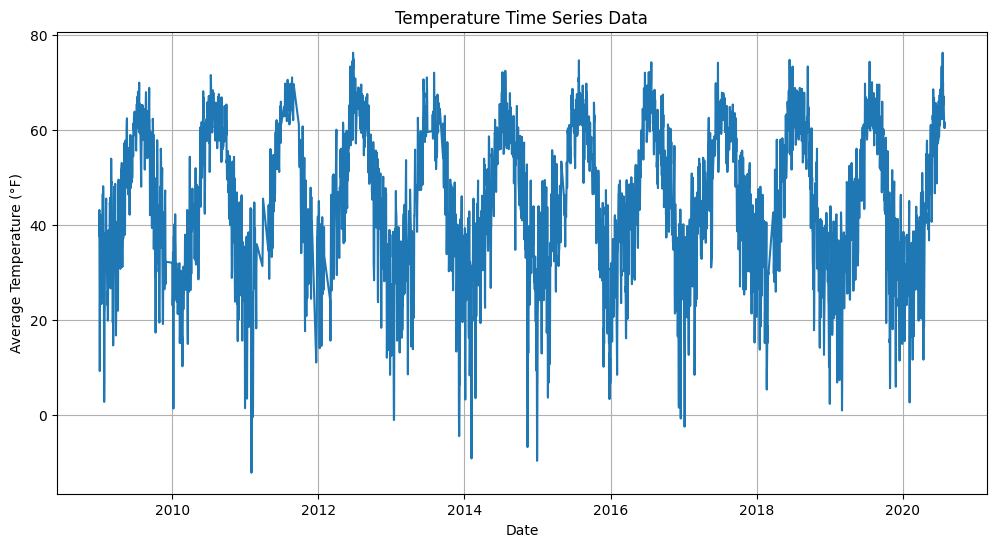

In [6]:
#可视化
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Average temperature (°F)'])
plt.title('Temperature Time Series Data')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°F)')
plt.grid(True)
plt.show()

In [7]:
data = df['Average temperature (°F)'].values
print(data.shape)
data = data.reshape(-1, 1)
print(data.shape)

(3902,)
(3902, 1)


In [8]:
# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [9]:
#创建含时间特征的数据
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)
time_step = 7
X, y = create_dataset(data_scaled, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print(X.shape, y.shape)

(3894, 7, 1) (3894,)


In [10]:
# 划分训练集和测试集（80%训练，20%测试）
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [11]:
# 创建PyTorch数据集和数据加载器
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [12]:
# 创建数据加载器
batch_size = 32
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=50, output_size=1, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, 
                           batch_first=True, dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_layer_size, 25)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(25, output_size)
        
    def forward(self, x):
        batch_size = x.size(0)
        
        # 初始化隐藏状态和单元状态
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).to(device)
        # 前向传播LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # 只取最后一个时间步的输出
        out = out[:, -1, :]
        
        # 全连接层
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

In [14]:
# 实例化模型
model = LSTMModel(input_size=1, hidden_layer_size=50, output_size=1, num_layers=2, dropout=0.2)
model = model.to(device)
print(model)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

LSTMModel(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.2)
  (fc1): Linear(in_features=50, out_features=25, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=25, out_features=1, bias=True)
)


/Users/kewuyu/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# 训练模型
num_epochs = 100
best_val_loss = float('inf')
patience = 10
counter = 0
train_losses = []
val_losses = []

# 验证函数
def validate(model, test_loader, criterion):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            val_loss += loss.item()
    return val_loss / len(test_loader)

# 训练循环
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # 前向传播
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # 计算平均训练损失
    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # 在验证集上评估模型
    val_loss = validate(model, test_loader, criterion)
    val_losses.append(val_loss)
    
    # 打印进度
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    # 早停机制
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # 保存最佳模型
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch 1/100, Train Loss: 0.041190, Val Loss: 0.011093
Epoch 2/100, Train Loss: 0.014169, Val Loss: 0.010146
Epoch 3/100, Train Loss: 0.013351, Val Loss: 0.010113
Epoch 4/100, Train Loss: 0.012665, Val Loss: 0.009445
Epoch 5/100, Train Loss: 0.011912, Val Loss: 0.009148
Epoch 6/100, Train Loss: 0.012480, Val Loss: 0.009069
Epoch 7/100, Train Loss: 0.011677, Val Loss: 0.009634
Epoch 8/100, Train Loss: 0.010970, Val Loss: 0.008650
Epoch 9/100, Train Loss: 0.010729, Val Loss: 0.009763
Epoch 10/100, Train Loss: 0.010215, Val Loss: 0.007276
Epoch 11/100, Train Loss: 0.009115, Val Loss: 0.006417
Epoch 12/100, Train Loss: 0.008615, Val Loss: 0.006476
Epoch 13/100, Train Loss: 0.008200, Val Loss: 0.005998
Epoch 14/100, Train Loss: 0.007914, Val Loss: 0.006133
Epoch 15/100, Train Loss: 0.007770, Val Loss: 0.005799
Epoch 16/100, Train Loss: 0.007800, Val Loss: 0.006758
Epoch 17/100, Train Loss: 0.008030, Val Loss: 0.006574
Epoch 18/100, Train Loss: 0.007501, Val Loss: 0.005865
Epoch 19/100, Train

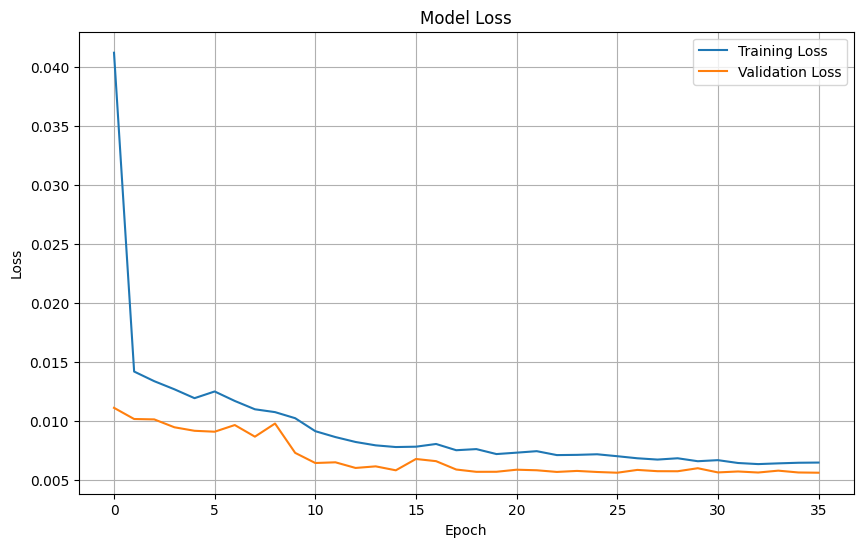

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

RMSE on test set: 6.66
MAE on test set: 4.98


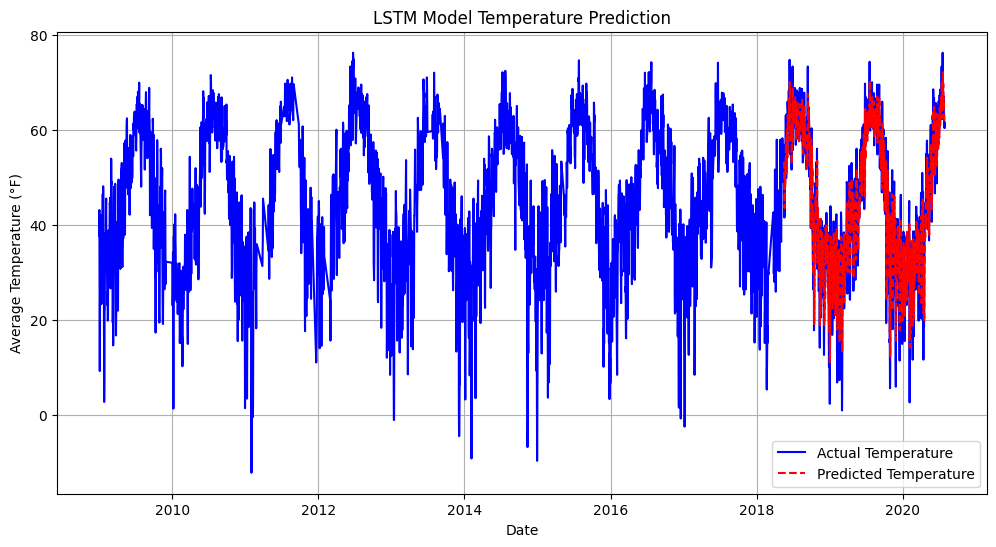

In [17]:
model.eval()

# 进行预测
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
with torch.no_grad():
    y_pred = model(X_test_tensor).cpu().numpy()

# 将预测值和实际值反归一化
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))

# 计算RMSE（均方根误差）
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'RMSE on test set: {rmse:.2f}')

# 计算MAE（平均绝对误差）
mae = np.mean(np.abs(y_test_inv - y_pred_inv))
print(f'MAE on test set: {mae:.2f}')

# 获取训练和测试数据的日期索引
train_data_len = train_size + time_step
test_dates = df.index[train_data_len:train_data_len+len(y_test_inv)]

# 绘制原始温度数据和预测结果
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Average temperature (°F)'], label='Actual Temperature', color='blue')
plt.plot(test_dates, y_pred_inv, label='Predicted Temperature', color='red', linestyle='--')
plt.title('LSTM Model Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°F)')
plt.legend()
plt.grid(True)
plt.show()

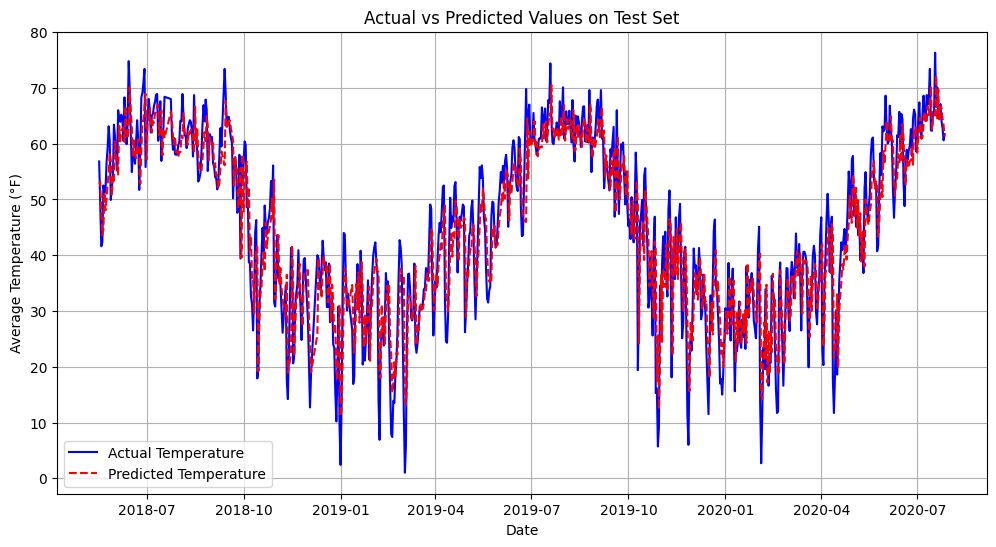

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_inv, label='Actual Temperature', color='blue')
plt.plot(test_dates, y_pred_inv, label='Predicted Temperature', color='red', linestyle='--')
plt.title('Actual vs Predicted Values on Test Set')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°F)')
plt.legend()
plt.grid(True)
plt.show()